In [10]:
import numpy as np
import time
from scipy import integrate, sin, cos, pi
from scipy.special import binom

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [11]:
elapsed_time = 0
maxStress = 0

L = 2
B = 1

E = 200*10**9
nu = 0.3
t0 = 0.1
D0 = E*t0**3/(12*(1-nu**2))

e = 0#(0.05-t0)/(t0*L)

In [12]:
def t(x):
    return t0*(1+e*x)

def D(x):
    return D0*(1+e*x)**3  #Di = D0*binom(3,i)*x**i

def Q(x,y):
    return -100*10**3

In [13]:
#N=1
def Analyze(x,y):
    start_time = time.time()

    W = 0
    Wxx = 0
    Wyy = 0
    Wxy = 0
    Mx = 0
    My = 0
    Mxy = 0
    z = t(x)/2
    w = np.zeros((N+1,N+1,3+1))
    for n in range(1,N+1):
        for m in range(1,N+1):
            for k in range(3+1):
                Int1=0
                Int2=0
                if(k==0):
                    f0 = lambda y,x: 4/(B*L*D0)*(Q(x,y)*sin(n*pi*x/L)*sin(m*pi*y/B))
                    w[m][n][k] = integrate.dblquad(f0, 0, L, lambda x: 0, lambda x: B )[0]/((n*pi/L)**2+(m*pi/B)**2)**2
                else:
                    for i in range(1,k+1):
                        for p in range(1,N+1):
                            for r in range(1,N+1):
                                fk1 = lambda y,x:(D0*binom(3,i)*x**i)*sin(p*pi*x/L)*sin(n*pi*x/L)*sin(r*pi*y/B)*sin(m*pi*y/B)
                                fk2 = lambda y,x:(D0*binom(3,i)*(i*(i-1))*x**(i-2))*sin(p*pi*x/L)*sin(n*pi*x/L)*sin(r*pi*y/B)*sin(m*pi*y/B)

                                Int1 += integrate.dblquad(fk1, 0, L, lambda x: 0, lambda x: B )[0]
                                Int2 += integrate.dblquad(fk2, 0, L, lambda x: 0, lambda x: B )[0]
                                
                            Int1 *= w[p][r][k-i]*((p*pi/L)**2+(r*pi/B)**2)**2
                            Int2 *= -w[p][r][k-i]*((p*pi/L)**2+nu*(r*pi/B)**2)
                    w[m][n][k] = (Int1+Int2)*(-4/(B*L*D0))/((n*pi/L)**2+(m*pi/B)**2)**2

                W += (w[m][n][k]*e**k)*sin(n*pi*x/L)*sin(m*pi*y/B)

                #----Calc Curvatures----#                
                Wxx += -(w[m][n][k]*e**k)*sin(n*pi*x/L)*sin(m*pi*y/B)*(n*pi/L)**2
                Wyy += -(w[m][n][k]*e**k)*sin(n*pi*x/L)*sin(m*pi*y/B)*(m*pi/B)**2
                Wxy += (w[m][n][k]*e**k)*cos(n*pi*x/L)*cos(m*pi*y/B)*(n*pi/L)*(m*pi/B)

                #----Calc Moments----#
                Mx = -D(x)*(Wxx+nu*Wyy)
                My = -D(x)*(Wyy+nu*Wxx)
                Mxy = -D(x)*(1-nu)*Wxy

                #----Calc Stresses----# 
                sxx = -E*z/(1-nu**2)*(Wxx+nu*Wyy)
                syy = -E*z/(1-nu**2)*(Wyy+nu*Wxx)
                sxy = -E*z/(2*(1+nu))*Wxy

                s1 = (sxx+syy)/2 + np.sqrt(((sxx-syy)/2)**2 + sxy**2) #principal stress
                s2 = (sxx+syy)/2 - np.sqrt(((sxx-syy)/2)**2 + sxy**2)

                sVM = np.sqrt(s1**2-s1*s2+s2**2) #Von Mises stress

    elapsed_time = time.time() - start_time
    
    return ((sxx,"Sxx"),(syy,"Syy"),(sxy, "Sxy"),(s1,"S1"),(s2,"S2"),(sVM, "SVM"),(Mx*1000, "Mx"),(My*1000, "My"),(Mxy*1000, "Mxy"),(W*1000,"W"))

In [14]:
def plot_stress():
    fig, ax = plt.subplots(3,3,sharey=False)
    
    x = np.linspace(0, L, 100)
    y = np.linspace(0, B, 100)
    X, Y = np.meshgrid(x, y)

    s = Analyze(X,Y)

    maxStress = '{:.4f}'.format(np.amax(s[5][0])*10**(-6)).replace(".",",")
        
    for i in range(3):
        for j in range(3):
            ax[i,j].imshow(s[j+i*3][0]*10**(-6), cmap='Spectral', origin='lower', extent=[0,L,0,B])
##            CS = ax[i,j].contour(X, Y,s[j+i*2+1][0]*10**(-6),8,extend='both')
##            ax[i,j].clabel(CS, inline=1, fontsize=10)
            ax[i,j].set_title(s[j+i*3][1], fontsize=12)

    plt.tight_layout(pad=1, w_pad=0.5, h_pad=1.0)
    fig.set_size_inches((16,8), forward=False)
    plt.savefig(f'img/(N={N})   (e={str(e).replace(".",",")})   (maxS={maxStress})   (t={elapsed_time})',dpi=500)
    plt.show()

In [ ]:
def plot_deflection():    
    fig = plt.figure()
    ax = plt.axes(projection="3d")

    x = np.linspace(0, L, 100)
    y = np.linspace(0, B, 100)
    X, Y = np.meshgrid(x, y)

    Z = Analyze(X,Y)[9][0]

    # Plot the 3D surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

    #2D PLot
    ##fig, ax = plt.subplots()
    ##ax.plot(x,Z,color='b')
    ##ax.plot(x,Z0,color='r', linestyle='--')
    ##ax.grid()

    # Customize the z axis.
    ax.set_zlim(-t0*1000,t0*1000)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()

Number of terms: 1


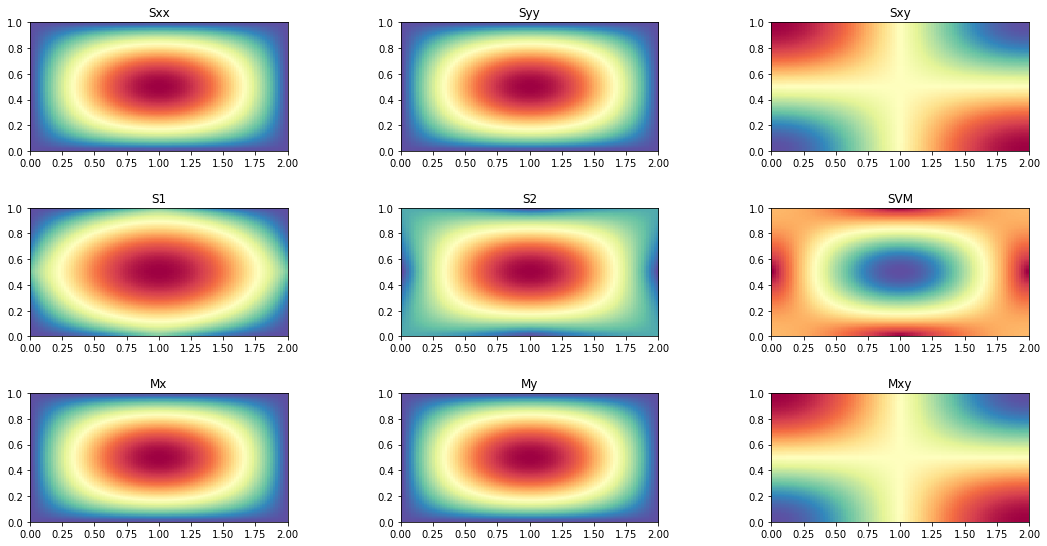

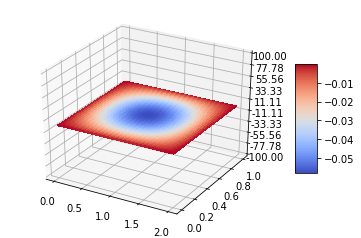

Number of terms: 2


d:\python\python36\lib\site-packages\scipy\integrate\quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


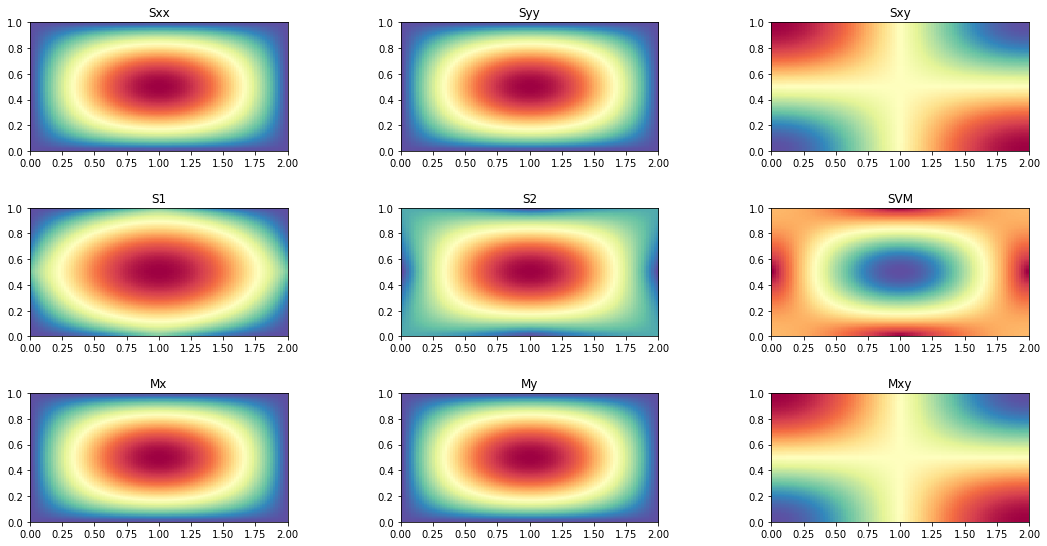

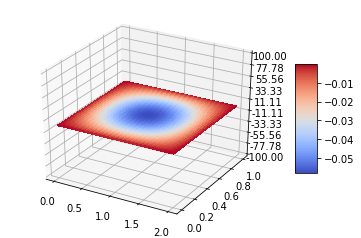

Number of terms: 3


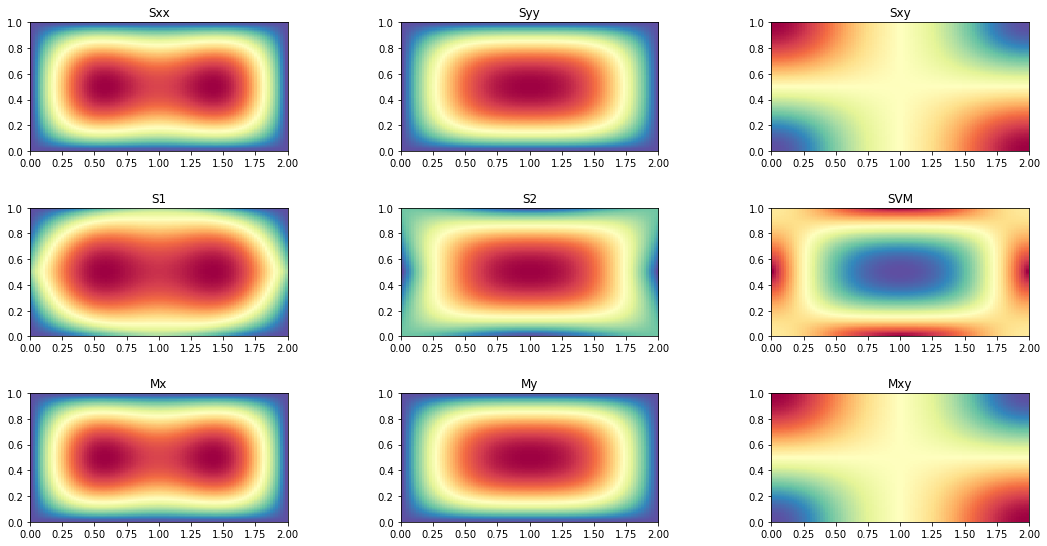

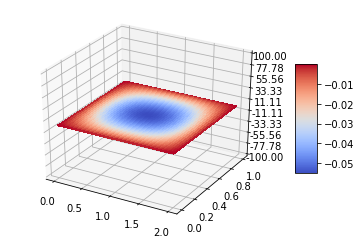

Number of terms: 4


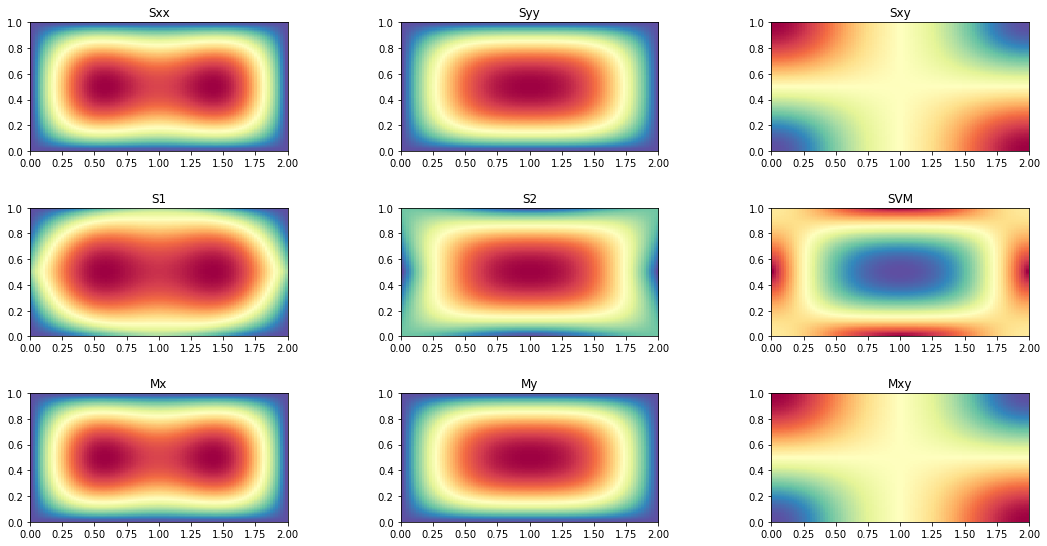

In [ ]:
#print(Analyze(L/2,B/2))
for N in range(1,5):
    print("Number of terms: "+str(N))
    plot_stress()
    plot_deflection()